In [1]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy.fuzzy_layer import FuzzyLayer

In [2]:
batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
output_dims = 2
beta = 1
gamma = 1 
unknown_classes_ratio = 0.0 # unknow samples rate
is_fuzzy_loss_active = True
is_fuzzy_cvae = True
is_multi_labled = True
if is_multi_labled:
    fuzzy_labels = 12 #10 numbers 
else:
    fuzzy_labels = 10 

prefix = "vae"
if is_fuzzy_loss_active:
    prefix = f"fuzzy_cvae_with_unknown_ratio_{unknown_classes_ratio}"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if is_fuzzy_loss_active:
    gamma = 1
else:
    gamma = 0

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [4]:
def get_target_and_mask(target_label, unknown_ratio):
    """
    Возвращает вектор целевого значения и маску в виде сдвоенного тензора

    Args:
        target_label (int): Метка класса
        unknown_ratio (float): Доля примеров в датасете, чья разметка будет игнорироваться при обучении
    
    Returns:
        tensor (2, 12)
    """
    t = F.one_hot(torch.LongTensor([target_label]), fuzzy_labels)
    if is_multi_labled:
        if (target_label == 0) or (target_label == 6) or (target_label == 8) or (target_label == 9):
            t[0][fuzzy_labels - 2] = 1
        else:
            t[0][fuzzy_labels - 1] = 1
    m = torch.ones((1, fuzzy_labels)) if torch.rand(1) > unknown_ratio else torch.zeros((1, fuzzy_labels))
    
    return torch.cat((t, m), 0).to(device) 

In [5]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x,unknown_classes_ratio))
)

In [6]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x, 0))
)
len(test_data)

10000

In [7]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [8]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

In [9]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(), 
            nn.Linear(625, 9216),
            nn.BatchNorm1d(9216),
            nn.SiLU(), 
            nn.Unflatten(1,(64, 12, 12)),
            nn.ConvTranspose2d(64, 32, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(32, 16, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(16, 8, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(8, 1, 5),
            nn.Sigmoid() 
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [10]:
class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder (C-VAE) 
    
    Args:
        latent_dim (int): Размер латентного вектора.
        labels_count (int): Количество выходов классификатора
    """
    def __init__(self, latent_dim, labels_count, output_dims, fuzzy):
        super(CVAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)
        self.output_dims = output_dims
        
        if fuzzy:
            self.output = nn.Sequential(
                FuzzyLayer.fromdimentions(output_dims, labels_count, trainable=True)
            )
        else:
            self.output = nn.Sequential(
                nn.Linear(output_dims, labels_count),
                nn.Sigmoid(),
                nn.Linear(labels_count, labels_count),
                nn.Sigmoid()
            )
        
        
    def forward(self, x):
        """
        Возвращает компоненты внутренних слоев CVAE, результаты реконструкции и классификации
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            mu, x_recon, labels
        """

        mu, _,  _, = self.encoder(x)
        x_recon = self.decoder(mu)
        
        labels = self.output(mu[:, :self.output_dims])

        return mu, x_recon, labels
    
    def half_pass(self, x):
        """
        Возвращает результаты работы энкодера и классификатора
        """
        mu, logvar, z = self.encoder(x)
        labels = self.output(mu[:, :self.output_dims])

        return mu, logvar, z, labels
    
    def decoder_pass(self, x):
        return self.decoder(x)


In [11]:
def compute_loss(x, recon_x, mu, logvar, z, target_labels, predicted_labels):
    
    loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
            
    target_firings = target_labels[:,0,:]
    mask = target_labels[:,1,:]
    loss_fuzzy = (mask * torch.square(target_firings - predicted_labels)).sum(-1).mean()

    loss = loss_recon + beta * loss_kl + gamma * loss_fuzzy

    

    return loss, loss_recon, loss_kl, loss_fuzzy
    

In [12]:
model = CVAE(latent_dim=latent_dim, labels_count=fuzzy_labels, output_dims=output_dims, fuzzy=is_fuzzy_cvae).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,690,329


CVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=4, bias=True)
    )
    (softplus): Softplus(beta=1.0, threshold=20.0)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=625, bias=True)
      (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [14]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, logcar, z, labels = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
        loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z, target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f} Fuzzy: {loss_fuzzy.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', loss_kl.item(), global_step)
                writer.add_scalar('Fuzzy/Train/Loss', loss_fuzzy.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [15]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_fuzzy_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            mu, logcar, z, labels = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z,  target, labels)
            
            test_loss += loss.item()
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            test_fuzzy_loss += loss_fuzzy.item()
            pred_target = np.argmax(labels[:, 0:10].cpu().numpy(), axis=1)
            target_labels =  np.argmax(target[:,0, 0:10].cpu().numpy(), axis=1)
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fuzzy_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} Fuzzy: {test_fuzzy_loss:.4f} Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', loss_kl.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Loss', loss_fuzzy.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Accuracy', test_accuracy, global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [627]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)


Epoch 1/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 21.2040 (Recon: 18.4613, KL: 0.1923 Fuzzy: 2.5504) Grad: 15.2192
Step 100 (N samples: 25,600), Loss: 9.1793 (Recon: 7.3949, KL: 0.3882 Fuzzy: 1.3962) Grad: 14.6594
Step 200 (N samples: 51,200), Loss: 8.4332 (Recon: 6.8261, KL: 0.4350 Fuzzy: 1.1722) Grad: 5.2384


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.4527 (BCE: 6.8016, KLD: 0.6338 Fuzzy: 1.0172 Accuracy 0.4383)
Epoch 2/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 300 (N samples: 76,800), Loss: 8.3770 (Recon: 6.9118, KL: 0.4765 Fuzzy: 0.9887) Grad: 3.7485
Step 400 (N samples: 102,400), Loss: 8.3544 (Recon: 6.9764, KL: 0.5046 Fuzzy: 0.8734) Grad: 3.4666


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.1180 (BCE: 6.6760, KLD: 0.6666 Fuzzy: 0.7753 Accuracy 0.5422)
Epoch 3/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 500 (N samples: 128,000), Loss: 8.0263 (Recon: 6.7063, KL: 0.5133 Fuzzy: 0.8067) Grad: 4.1810
Step 600 (N samples: 153,600), Loss: 7.9644 (Recon: 6.7359, KL: 0.5479 Fuzzy: 0.6806) Grad: 2.5876
Step 700 (N samples: 179,200), Loss: 7.9438 (Recon: 6.7452, KL: 0.5809 Fuzzy: 0.6177) Grad: 2.3034


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.8775 (BCE: 6.6565, KLD: 0.5991 Fuzzy: 0.6219 Accuracy 0.6969)
Epoch 4/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 800 (N samples: 204,800), Loss: 7.6610 (Recon: 6.5397, KL: 0.5448 Fuzzy: 0.5765) Grad: 2.8345
Step 900 (N samples: 230,400), Loss: 7.8181 (Recon: 6.6220, KL: 0.6257 Fuzzy: 0.5704) Grad: 4.2606


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.7741 (BCE: 6.6359, KLD: 0.6255 Fuzzy: 0.5127 Accuracy 0.7371)
Epoch 5/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,000 (N samples: 256,000), Loss: 7.8605 (Recon: 6.7155, KL: 0.5968 Fuzzy: 0.5481) Grad: 2.2692
Step 1,100 (N samples: 281,600), Loss: 7.9351 (Recon: 6.8612, KL: 0.5946 Fuzzy: 0.4793) Grad: 3.0814


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.7094 (BCE: 6.5607, KLD: 0.6868 Fuzzy: 0.4619 Accuracy 0.7739)
Epoch 6/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,200 (N samples: 307,200), Loss: 7.7679 (Recon: 6.6282, KL: 0.6472 Fuzzy: 0.4925) Grad: 2.9522
Step 1,300 (N samples: 332,800), Loss: 7.7820 (Recon: 6.7157, KL: 0.6400 Fuzzy: 0.4263) Grad: 1.7913
Step 1,400 (N samples: 358,400), Loss: 7.3436 (Recon: 6.3503, KL: 0.6171 Fuzzy: 0.3763) Grad: 3.6908


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.6155 (BCE: 6.5441, KLD: 0.6797 Fuzzy: 0.3917 Accuracy 0.8526)
Epoch 7/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,500 (N samples: 384,000), Loss: 7.5183 (Recon: 6.5097, KL: 0.6460 Fuzzy: 0.3627) Grad: 2.6318
Step 1,600 (N samples: 409,600), Loss: 7.5355 (Recon: 6.5529, KL: 0.6702 Fuzzy: 0.3124) Grad: 2.7201


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.6023 (BCE: 6.4995, KLD: 0.7584 Fuzzy: 0.3445 Accuracy 0.9013)
Epoch 8/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,700 (N samples: 435,200), Loss: 7.5815 (Recon: 6.5624, KL: 0.6925 Fuzzy: 0.3266) Grad: 2.2831
Step 1,800 (N samples: 460,800), Loss: 7.4589 (Recon: 6.4523, KL: 0.6957 Fuzzy: 0.3110) Grad: 2.7689


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4910 (BCE: 6.4500, KLD: 0.7514 Fuzzy: 0.2896 Accuracy 0.9388)
Epoch 9/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,900 (N samples: 486,400), Loss: 7.4502 (Recon: 6.3683, KL: 0.7062 Fuzzy: 0.3757) Grad: 3.4184
Step 2,000 (N samples: 512,000), Loss: 7.5141 (Recon: 6.4462, KL: 0.7109 Fuzzy: 0.3570) Grad: 3.2138
Step 2,100 (N samples: 537,600), Loss: 7.5330 (Recon: 6.4926, KL: 0.7392 Fuzzy: 0.3011) Grad: 2.4602


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4839 (BCE: 6.4467, KLD: 0.7656 Fuzzy: 0.2716 Accuracy 0.9455)
Epoch 10/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,200 (N samples: 563,200), Loss: 7.5935 (Recon: 6.5165, KL: 0.7855 Fuzzy: 0.2916) Grad: 2.6911
Step 2,300 (N samples: 588,800), Loss: 7.7317 (Recon: 6.6994, KL: 0.7634 Fuzzy: 0.2688) Grad: 2.4675


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4535 (BCE: 6.4007, KLD: 0.7746 Fuzzy: 0.2782 Accuracy 0.9431)
Epoch 11/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,400 (N samples: 614,400), Loss: 7.3932 (Recon: 6.3964, KL: 0.7598 Fuzzy: 0.2371) Grad: 2.3580
Step 2,500 (N samples: 640,000), Loss: 7.2924 (Recon: 6.2652, KL: 0.7871 Fuzzy: 0.2401) Grad: 2.2339


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4402 (BCE: 6.4639, KLD: 0.7262 Fuzzy: 0.2502 Accuracy 0.9477)
Epoch 12/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,600 (N samples: 665,600), Loss: 7.5793 (Recon: 6.5619, KL: 0.7458 Fuzzy: 0.2715) Grad: 3.1408
Step 2,700 (N samples: 691,200), Loss: 7.4111 (Recon: 6.3280, KL: 0.7897 Fuzzy: 0.2934) Grad: 3.1733
Step 2,800 (N samples: 716,800), Loss: 7.7520 (Recon: 6.6959, KL: 0.7660 Fuzzy: 0.2901) Grad: 2.2465


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3952 (BCE: 6.3905, KLD: 0.7678 Fuzzy: 0.2369 Accuracy 0.9538)
Epoch 13/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,900 (N samples: 742,400), Loss: 7.4454 (Recon: 6.4250, KL: 0.7769 Fuzzy: 0.2436) Grad: 2.1426
Step 3,000 (N samples: 768,000), Loss: 7.3749 (Recon: 6.3322, KL: 0.8016 Fuzzy: 0.2412) Grad: 3.6515


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3977 (BCE: 6.4066, KLD: 0.7559 Fuzzy: 0.2351 Accuracy 0.9542)
Epoch 14/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,100 (N samples: 793,600), Loss: 7.4281 (Recon: 6.4026, KL: 0.7896 Fuzzy: 0.2360) Grad: 2.1954
Step 3,200 (N samples: 819,200), Loss: 7.4740 (Recon: 6.4546, KL: 0.7842 Fuzzy: 0.2352) Grad: 3.9285


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3693 (BCE: 6.3046, KLD: 0.8449 Fuzzy: 0.2199 Accuracy 0.9599)
Epoch 15/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,300 (N samples: 844,800), Loss: 7.2883 (Recon: 6.2430, KL: 0.8180 Fuzzy: 0.2272) Grad: 2.3061
Step 3,400 (N samples: 870,400), Loss: 7.5624 (Recon: 6.4594, KL: 0.8200 Fuzzy: 0.2830) Grad: 2.9775
Step 3,500 (N samples: 896,000), Loss: 7.4324 (Recon: 6.4226, KL: 0.7820 Fuzzy: 0.2279) Grad: 1.9858


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4015 (BCE: 6.3950, KLD: 0.7652 Fuzzy: 0.2413 Accuracy 0.9515)
Epoch 16/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,600 (N samples: 921,600), Loss: 7.3732 (Recon: 6.3764, KL: 0.7961 Fuzzy: 0.2006) Grad: 1.8544
Step 3,700 (N samples: 947,200), Loss: 7.4372 (Recon: 6.3873, KL: 0.8458 Fuzzy: 0.2042) Grad: 2.2078


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4070 (BCE: 6.3599, KLD: 0.8103 Fuzzy: 0.2368 Accuracy 0.9565)
Epoch 17/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,800 (N samples: 972,800), Loss: 7.5599 (Recon: 6.4259, KL: 0.8031 Fuzzy: 0.3308) Grad: 3.7963
Step 3,900 (N samples: 998,400), Loss: 7.5301 (Recon: 6.5077, KL: 0.7817 Fuzzy: 0.2407) Grad: 2.9125


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3630 (BCE: 6.3296, KLD: 0.8172 Fuzzy: 0.2163 Accuracy 0.9616)
Epoch 18/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,000 (N samples: 1,024,000), Loss: 7.3747 (Recon: 6.3570, KL: 0.7735 Fuzzy: 0.2442) Grad: 2.2027
Step 4,100 (N samples: 1,049,600), Loss: 7.2540 (Recon: 6.2091, KL: 0.8025 Fuzzy: 0.2424) Grad: 2.7356
Step 4,200 (N samples: 1,075,200), Loss: 7.4306 (Recon: 6.4358, KL: 0.7803 Fuzzy: 0.2145) Grad: 2.3641


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3531 (BCE: 6.3145, KLD: 0.8223 Fuzzy: 0.2163 Accuracy 0.9643)
Epoch 19/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,300 (N samples: 1,100,800), Loss: 7.4639 (Recon: 6.3778, KL: 0.8325 Fuzzy: 0.2536) Grad: 2.7480
Step 4,400 (N samples: 1,126,400), Loss: 7.5227 (Recon: 6.4481, KL: 0.7917 Fuzzy: 0.2829) Grad: 3.5445


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3421 (BCE: 6.3181, KLD: 0.8154 Fuzzy: 0.2085 Accuracy 0.9580)
Epoch 20/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,500 (N samples: 1,152,000), Loss: 7.7516 (Recon: 6.7375, KL: 0.7894 Fuzzy: 0.2247) Grad: 2.1921
Step 4,600 (N samples: 1,177,600), Loss: 7.4089 (Recon: 6.3553, KL: 0.8204 Fuzzy: 0.2332) Grad: 2.8119


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3837 (BCE: 6.3292, KLD: 0.8240 Fuzzy: 0.2305 Accuracy 0.9607)
Epoch 21/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,700 (N samples: 1,203,200), Loss: 7.3292 (Recon: 6.2628, KL: 0.8206 Fuzzy: 0.2457) Grad: 3.0744
Step 4,800 (N samples: 1,228,800), Loss: 7.3030 (Recon: 6.2587, KL: 0.8259 Fuzzy: 0.2185) Grad: 1.9124
Step 4,900 (N samples: 1,254,400), Loss: 7.4890 (Recon: 6.4430, KL: 0.8011 Fuzzy: 0.2450) Grad: 2.8469


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3647 (BCE: 6.3646, KLD: 0.7906 Fuzzy: 0.2095 Accuracy 0.9624)
Epoch 22/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,000 (N samples: 1,280,000), Loss: 7.3887 (Recon: 6.3590, KL: 0.7948 Fuzzy: 0.2348) Grad: 2.8245
Step 5,100 (N samples: 1,305,600), Loss: 7.4724 (Recon: 6.4442, KL: 0.8327 Fuzzy: 0.1955) Grad: 2.0614


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3346 (BCE: 6.2988, KLD: 0.8352 Fuzzy: 0.2006 Accuracy 0.9647)
Epoch 23/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,200 (N samples: 1,331,200), Loss: 7.2627 (Recon: 6.2151, KL: 0.8137 Fuzzy: 0.2339) Grad: 2.8932
Step 5,300 (N samples: 1,356,800), Loss: 7.3935 (Recon: 6.3377, KL: 0.8383 Fuzzy: 0.2175) Grad: 1.9227
Step 5,400 (N samples: 1,382,400), Loss: 7.5084 (Recon: 6.4080, KL: 0.8461 Fuzzy: 0.2542) Grad: 2.3956


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3138 (BCE: 6.2712, KLD: 0.8411 Fuzzy: 0.2015 Accuracy 0.9646)
Epoch 24/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,500 (N samples: 1,408,000), Loss: 7.3054 (Recon: 6.2079, KL: 0.8470 Fuzzy: 0.2506) Grad: 2.3691
Step 5,600 (N samples: 1,433,600), Loss: 7.3506 (Recon: 6.2825, KL: 0.8150 Fuzzy: 0.2532) Grad: 3.9140


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3297 (BCE: 6.2635, KLD: 0.8681 Fuzzy: 0.1982 Accuracy 0.9655)
Epoch 25/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,700 (N samples: 1,459,200), Loss: 7.1317 (Recon: 6.1063, KL: 0.8060 Fuzzy: 0.2194) Grad: 2.1656
Step 5,800 (N samples: 1,484,800), Loss: 7.5673 (Recon: 6.5039, KL: 0.8580 Fuzzy: 0.2055) Grad: 1.9589


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3391 (BCE: 6.2773, KLD: 0.8555 Fuzzy: 0.2063 Accuracy 0.9658)
Epoch 26/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,900 (N samples: 1,510,400), Loss: 7.4650 (Recon: 6.4206, KL: 0.8093 Fuzzy: 0.2351) Grad: 3.3565
Step 6,000 (N samples: 1,536,000), Loss: 7.4316 (Recon: 6.4075, KL: 0.8134 Fuzzy: 0.2107) Grad: 2.1629
Step 6,100 (N samples: 1,561,600), Loss: 7.4035 (Recon: 6.3672, KL: 0.8358 Fuzzy: 0.2005) Grad: 2.9273


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3277 (BCE: 6.2795, KLD: 0.8416 Fuzzy: 0.2067 Accuracy 0.9694)
Epoch 27/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,200 (N samples: 1,587,200), Loss: 7.3950 (Recon: 6.3568, KL: 0.8299 Fuzzy: 0.2083) Grad: 2.7646
Step 6,300 (N samples: 1,612,800), Loss: 7.2225 (Recon: 6.1780, KL: 0.8549 Fuzzy: 0.1896) Grad: 2.4260


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3113 (BCE: 6.2978, KLD: 0.8238 Fuzzy: 0.1897 Accuracy 0.9662)
Epoch 28/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,400 (N samples: 1,638,400), Loss: 7.4580 (Recon: 6.4507, KL: 0.8368 Fuzzy: 0.1706) Grad: 1.8516
Step 6,500 (N samples: 1,664,000), Loss: 7.5145 (Recon: 6.4561, KL: 0.8420 Fuzzy: 0.2163) Grad: 2.4511


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3442 (BCE: 6.3148, KLD: 0.8192 Fuzzy: 0.2102 Accuracy 0.9646)
Epoch 29/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,600 (N samples: 1,689,600), Loss: 7.0784 (Recon: 6.0530, KL: 0.8558 Fuzzy: 0.1696) Grad: 1.8041
Step 6,700 (N samples: 1,715,200), Loss: 7.3719 (Recon: 6.3386, KL: 0.8452 Fuzzy: 0.1880) Grad: 2.0302
Step 6,800 (N samples: 1,740,800), Loss: 7.5551 (Recon: 6.5044, KL: 0.8634 Fuzzy: 0.1873) Grad: 1.8221


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2980 (BCE: 6.2728, KLD: 0.8366 Fuzzy: 0.1886 Accuracy 0.9664)
Epoch 30/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,900 (N samples: 1,766,400), Loss: 7.3512 (Recon: 6.2690, KL: 0.8527 Fuzzy: 0.2295) Grad: 2.7446
Step 7,000 (N samples: 1,792,000), Loss: 7.2957 (Recon: 6.2313, KL: 0.8568 Fuzzy: 0.2075) Grad: 1.5145


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3219 (BCE: 6.2849, KLD: 0.8526 Fuzzy: 0.1844 Accuracy 0.9705)
Epoch 31/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,100 (N samples: 1,817,600), Loss: 7.2949 (Recon: 6.2531, KL: 0.8537 Fuzzy: 0.1881) Grad: 1.9612
Step 7,200 (N samples: 1,843,200), Loss: 7.3359 (Recon: 6.2938, KL: 0.8210 Fuzzy: 0.2211) Grad: 2.5289


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3043 (BCE: 6.2723, KLD: 0.8422 Fuzzy: 0.1899 Accuracy 0.9704)
Epoch 32/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,300 (N samples: 1,868,800), Loss: 7.3993 (Recon: 6.3903, KL: 0.8221 Fuzzy: 0.1869) Grad: 2.0949
Step 7,400 (N samples: 1,894,400), Loss: 7.1587 (Recon: 6.1435, KL: 0.8321 Fuzzy: 0.1832) Grad: 1.9375
Step 7,500 (N samples: 1,920,000), Loss: 7.2923 (Recon: 6.2653, KL: 0.8526 Fuzzy: 0.1744) Grad: 1.7280


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2882 (BCE: 6.2414, KLD: 0.8624 Fuzzy: 0.1844 Accuracy 0.9699)
Epoch 33/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,600 (N samples: 1,945,600), Loss: 7.2573 (Recon: 6.2027, KL: 0.8603 Fuzzy: 0.1943) Grad: 2.0328
Step 7,700 (N samples: 1,971,200), Loss: 7.5496 (Recon: 6.4782, KL: 0.8460 Fuzzy: 0.2254) Grad: 2.7740


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3193 (BCE: 6.3018, KLD: 0.8299 Fuzzy: 0.1876 Accuracy 0.9703)
Epoch 34/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,800 (N samples: 1,996,800), Loss: 7.1201 (Recon: 6.0616, KL: 0.8742 Fuzzy: 0.1843) Grad: 2.2502
Step 7,900 (N samples: 2,022,400), Loss: 7.2691 (Recon: 6.2063, KL: 0.8667 Fuzzy: 0.1961) Grad: 2.0210


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3218 (BCE: 6.2993, KLD: 0.8369 Fuzzy: 0.1856 Accuracy 0.9687)
Epoch 35/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,000 (N samples: 2,048,000), Loss: 7.3223 (Recon: 6.2877, KL: 0.8766 Fuzzy: 0.1580) Grad: 2.0989
Step 8,100 (N samples: 2,073,600), Loss: 7.3048 (Recon: 6.2532, KL: 0.8637 Fuzzy: 0.1878) Grad: 2.5404
Step 8,200 (N samples: 2,099,200), Loss: 7.4499 (Recon: 6.3661, KL: 0.8620 Fuzzy: 0.2219) Grad: 2.5973


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3080 (BCE: 6.2895, KLD: 0.8305 Fuzzy: 0.1879 Accuracy 0.9716)
Epoch 36/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,300 (N samples: 2,124,800), Loss: 7.3586 (Recon: 6.3246, KL: 0.8667 Fuzzy: 0.1673) Grad: 2.5906
Step 8,400 (N samples: 2,150,400), Loss: 7.3407 (Recon: 6.2637, KL: 0.8413 Fuzzy: 0.2357) Grad: 2.5480


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3204 (BCE: 6.2889, KLD: 0.8431 Fuzzy: 0.1883 Accuracy 0.9722)
Epoch 37/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,500 (N samples: 2,176,000), Loss: 7.4144 (Recon: 6.2995, KL: 0.8556 Fuzzy: 0.2593) Grad: 3.7448
Step 8,600 (N samples: 2,201,600), Loss: 7.2391 (Recon: 6.1623, KL: 0.8738 Fuzzy: 0.2030) Grad: 1.8056


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3158 (BCE: 6.2828, KLD: 0.8501 Fuzzy: 0.1829 Accuracy 0.9717)
Epoch 38/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,700 (N samples: 2,227,200), Loss: 7.2930 (Recon: 6.2269, KL: 0.8489 Fuzzy: 0.2173) Grad: 2.7104
Step 8,800 (N samples: 2,252,800), Loss: 7.4937 (Recon: 6.4537, KL: 0.8462 Fuzzy: 0.1938) Grad: 2.4595
Step 8,900 (N samples: 2,278,400), Loss: 7.2500 (Recon: 6.2189, KL: 0.8354 Fuzzy: 0.1958) Grad: 2.6209


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2788 (BCE: 6.2317, KLD: 0.8647 Fuzzy: 0.1824 Accuracy 0.9728)
Epoch 39/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,000 (N samples: 2,304,000), Loss: 7.4287 (Recon: 6.3590, KL: 0.8405 Fuzzy: 0.2292) Grad: 2.3962
Step 9,100 (N samples: 2,329,600), Loss: 7.4268 (Recon: 6.4039, KL: 0.8456 Fuzzy: 0.1773) Grad: 1.9970


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2878 (BCE: 6.2357, KLD: 0.8730 Fuzzy: 0.1791 Accuracy 0.9746)
Epoch 40/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,200 (N samples: 2,355,200), Loss: 7.4932 (Recon: 6.4189, KL: 0.8602 Fuzzy: 0.2140) Grad: 1.8604
Step 9,300 (N samples: 2,380,800), Loss: 7.4503 (Recon: 6.3640, KL: 0.8541 Fuzzy: 0.2322) Grad: 2.6239


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3013 (BCE: 6.2386, KLD: 0.8791 Fuzzy: 0.1837 Accuracy 0.9717)
Epoch 41/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,400 (N samples: 2,406,400), Loss: 7.5435 (Recon: 6.4963, KL: 0.8710 Fuzzy: 0.1762) Grad: 1.9838
Step 9,500 (N samples: 2,432,000), Loss: 7.2884 (Recon: 6.1859, KL: 0.8801 Fuzzy: 0.2223) Grad: 2.8025
Step 9,600 (N samples: 2,457,600), Loss: 7.2722 (Recon: 6.2420, KL: 0.8495 Fuzzy: 0.1807) Grad: 1.5986


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3087 (BCE: 6.2458, KLD: 0.8755 Fuzzy: 0.1874 Accuracy 0.9691)
Epoch 42/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,700 (N samples: 2,483,200), Loss: 7.4241 (Recon: 6.3467, KL: 0.8947 Fuzzy: 0.1826) Grad: 2.1230
Step 9,800 (N samples: 2,508,800), Loss: 7.2968 (Recon: 6.2513, KL: 0.8823 Fuzzy: 0.1632) Grad: 1.8943


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2979 (BCE: 6.2589, KLD: 0.8584 Fuzzy: 0.1806 Accuracy 0.9718)
Epoch 43/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,900 (N samples: 2,534,400), Loss: 7.2772 (Recon: 6.1875, KL: 0.9031 Fuzzy: 0.1867) Grad: 2.5230
Step 10,000 (N samples: 2,560,000), Loss: 7.2877 (Recon: 6.2135, KL: 0.8833 Fuzzy: 0.1910) Grad: 1.9796
Step 10,100 (N samples: 2,585,600), Loss: 7.3479 (Recon: 6.2950, KL: 0.8554 Fuzzy: 0.1975) Grad: 3.1277


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3023 (BCE: 6.2351, KLD: 0.8654 Fuzzy: 0.2018 Accuracy 0.9677)
Epoch 44/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,200 (N samples: 2,611,200), Loss: 7.3919 (Recon: 6.3349, KL: 0.8808 Fuzzy: 0.1762) Grad: 2.3568
Step 10,300 (N samples: 2,636,800), Loss: 7.2340 (Recon: 6.1843, KL: 0.8829 Fuzzy: 0.1669) Grad: 2.0654


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2776 (BCE: 6.2085, KLD: 0.8929 Fuzzy: 0.1762 Accuracy 0.9730)
Epoch 45/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,400 (N samples: 2,662,400), Loss: 7.1543 (Recon: 6.0853, KL: 0.8814 Fuzzy: 0.1875) Grad: 1.6966
Step 10,500 (N samples: 2,688,000), Loss: 7.3890 (Recon: 6.3362, KL: 0.8686 Fuzzy: 0.1842) Grad: 2.3890


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2913 (BCE: 6.2325, KLD: 0.8830 Fuzzy: 0.1758 Accuracy 0.9704)
Epoch 46/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,600 (N samples: 2,713,600), Loss: 7.2385 (Recon: 6.2103, KL: 0.8727 Fuzzy: 0.1556) Grad: 2.0371
Step 10,700 (N samples: 2,739,200), Loss: 7.3230 (Recon: 6.2538, KL: 0.8752 Fuzzy: 0.1940) Grad: 3.0556
Step 10,800 (N samples: 2,764,800), Loss: 7.2450 (Recon: 6.1675, KL: 0.9030 Fuzzy: 0.1745) Grad: 2.3607


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2925 (BCE: 6.2377, KLD: 0.8737 Fuzzy: 0.1811 Accuracy 0.9719)
Epoch 47/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,900 (N samples: 2,790,400), Loss: 7.1753 (Recon: 6.1380, KL: 0.8534 Fuzzy: 0.1839) Grad: 2.6270
Step 11,000 (N samples: 2,816,000), Loss: 7.2657 (Recon: 6.2067, KL: 0.8765 Fuzzy: 0.1825) Grad: 1.8478


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2776 (BCE: 6.2437, KLD: 0.8551 Fuzzy: 0.1788 Accuracy 0.9727)
Epoch 48/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,100 (N samples: 2,841,600), Loss: 7.3412 (Recon: 6.2508, KL: 0.8878 Fuzzy: 0.2026) Grad: 2.5267
Step 11,200 (N samples: 2,867,200), Loss: 7.4400 (Recon: 6.3481, KL: 0.8570 Fuzzy: 0.2350) Grad: 2.2195


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2664 (BCE: 6.2360, KLD: 0.8592 Fuzzy: 0.1712 Accuracy 0.9723)
Epoch 49/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,300 (N samples: 2,892,800), Loss: 7.3611 (Recon: 6.2764, KL: 0.8697 Fuzzy: 0.2151) Grad: 2.7762
Step 11,400 (N samples: 2,918,400), Loss: 7.3784 (Recon: 6.3104, KL: 0.8798 Fuzzy: 0.1882) Grad: 2.1984
Step 11,500 (N samples: 2,944,000), Loss: 7.2930 (Recon: 6.2505, KL: 0.8750 Fuzzy: 0.1675) Grad: 2.3371


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2787 (BCE: 6.2308, KLD: 0.8707 Fuzzy: 0.1773 Accuracy 0.9704)
Epoch 50/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,600 (N samples: 2,969,600), Loss: 7.1291 (Recon: 6.0874, KL: 0.8926 Fuzzy: 0.1492) Grad: 1.7664
Step 11,700 (N samples: 2,995,200), Loss: 7.2784 (Recon: 6.1777, KL: 0.8857 Fuzzy: 0.2150) Grad: 3.1619


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2864 (BCE: 6.2486, KLD: 0.8615 Fuzzy: 0.1763 Accuracy 0.9681)


In [16]:
if is_fuzzy_loss_active:
    print(f"./{'fz' if is_fuzzy_cvae else 'mlp'}_{latent_dim}_{fuzzy_labels}.pt")
    torch.save(model, f"./{'fz' if is_fuzzy_cvae else 'mlp'}_{latent_dim}_{fuzzy_labels}.pt")
else:
    print(f"./vae_{latent_dim}_{fuzzy_labels}.pt")
    torch.save(model, f"./vae_{latent_dim}_{fuzzy_labels}.pt")

./fz_2_12.pt


In [38]:
model = torch.load(f"./runs/mnist/fz_6_10.pt")
is_fuzzy_cvae = True
is_fuzzy_loss_active = True
is_multi_labled = False
if is_multi_labled:
    fuzzy_labels = 12 #10 numbers 
else:
    fuzzy_labels = 10 

In [39]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('cvae_mnist.webp')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x2 and 6x625)

In [40]:
# encode and plot the z values for the train set 
model.eval()
Z = [[] for _ in range(10)]
z_all = []
y_all = []
y_shape = []
pred_y_all = []
pred_y_shape = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        target_digits = np.argmax(target[:,0, 0:10].cpu().numpy(), axis=1)
        data = data.view((-1,1,28,28)).to(device)
        mu, logvar, z, labels = model.half_pass(data)
        mu_cpu = mu.cpu().numpy()
        z_all.append(mu_cpu)
        y_all.append(np.argmax(target[:,0, 0:10].cpu().numpy(), axis=1))
        pred_y_all.append(np.argmax(labels[:, 0:10].cpu().numpy(), axis=1))
        if is_multi_labled:
            y_shape.append(np.argmax(target[:,0, 10:].cpu().numpy(), axis=1))
            pred_y_shape.append(np.argmax(labels[:, 10:].cpu().numpy(), axis=1))
            for i, td in enumerate(target_digits):
                Z[td].append(mu_cpu[i])

z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
if is_multi_labled:
    Z = [np.array(z) for z in Z]            
    pred_y_shape = np.concatenate(pred_y_shape, axis=0)
    y_shape = np.concatenate(y_shape, axis=0)
pred_y_all = np.concatenate(pred_y_all, axis=0)

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [41]:
from collections import defaultdict

data_centroids_dict = defaultdict(list)

for mu, y in zip(z_all, pred_y_all):
    data_centroids_dict[y].append(mu)

cluster_centroids_from_data = []

for numb in range(0,10):
    cluster_centroids_from_data.append(np.mean(data_centroids_dict[numb], axis=0))


cluster_centroids_from_data

[array([ 0.28091565, -0.07695096,  0.07438048, -0.023931  , -0.77470785,
         0.70338213], dtype=float32),
 array([-0.2919468 ,  0.2115241 , -0.0225456 , -0.01971883,  1.0742805 ,
        -0.34580064], dtype=float32),
 array([ 0.40562114, -0.7786405 , -0.562654  ,  0.00639221, -0.03332224,
        -0.01975684], dtype=float32),
 array([-0.05606898, -0.81006706,  0.32219896, -0.00868652, -0.2446206 ,
        -0.24979559], dtype=float32),
 array([-0.3432396 ,  0.8210312 ,  0.12419668,  0.01927778, -0.22045659,
        -0.04368693], dtype=float32),
 array([ 0.04513447, -0.27012756,  0.40210176, -0.00159088, -0.07296488,
         0.25949407], dtype=float32),
 array([-0.45022875, -0.12840644, -0.71594465,  0.00355916, -0.33279583,
        -0.09678366], dtype=float32),
 array([ 0.5159378 ,  0.61631477, -0.34858376,  0.00248763,  0.10623281,
        -0.06143662], dtype=float32),
 array([-0.23406897, -0.3668013 ,  0.6220045 , -0.00065981,  0.05673717,
        -0.05149126], dtype=float32),
 

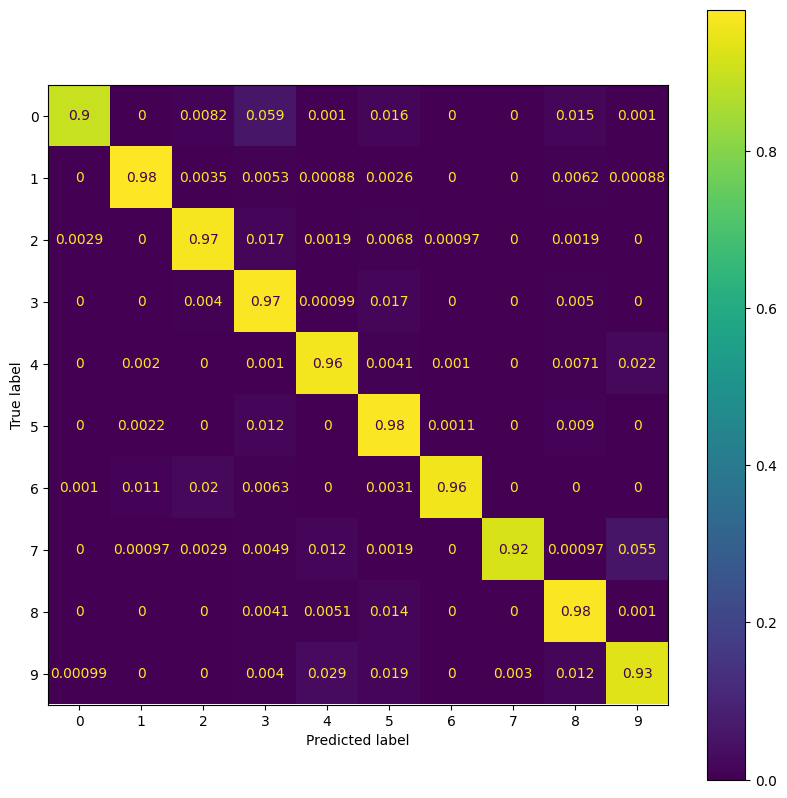

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_all, pred_y_all, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize = (10, 10))
cmd.plot(ax=ax)

In [541]:
def class_scatter(ax, x1, x2, y, x_label, y_label, title, **kwargs):    
    unique = list(set(y))
    colors = [plt.cm.tab10(float(i)/len(unique)) for i, _ in enumerate(unique)]
    for i, u in enumerate(unique):
        x1i = [x1[j] for j in range(len(x1)) if y[j] == u]
        x2i = [x2[j] for j in range(len(x2)) if y[j] == u]
        ax.scatter(x1i, x2i, c=colors[i], label=str(u), **kwargs)
    ax.legend(loc='upper left')
    if ax is plt:
        ax.xlabel(x_label)
        ax.ylabel(y_label)
        ax.title(title)
    else:
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)


/tmp/ipykernel_16402/1618381975.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x1i, x2i, c=colors[i], label=str(u), **kwargs)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


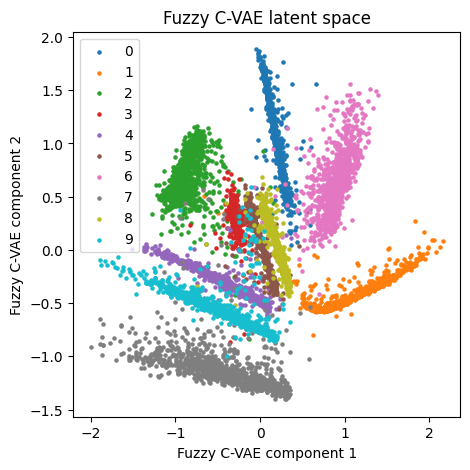

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


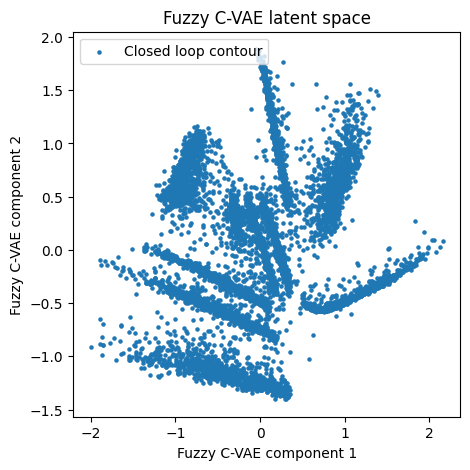

In [542]:
mask = "Fuzzy C-VAE" if is_fuzzy_cvae else "MLP C-VAE"
if not is_fuzzy_loss_active:
    mask = "VAE"

plt.figure(figsize=(5, 5))
class_scatter(plt, z_all[:, 0], z_all[:, 1], y_all, f"{mask} component 1", f"{mask} component 2", f'{mask} latent space', s=5)
save_path = f'./papers/iiti24/fig2c-{"fcvae" if is_fuzzy_cvae else "mlpcvae"}-all-features.eps' if is_fuzzy_loss_active else './papers/iiti24/fig2c-vae-all-features.eps'
plt.savefig(save_path, format='eps')
plt.show()
if is_multi_labled:
    plt.figure(figsize=(5, 5))
    class_scatter(plt, z_all[:, 0], z_all[:, 1], ["Closed loop contour" if x == 0 else "Not closed loop contour" for x in y_shape], f"{mask} component 1", f"{mask} component 2", f'{mask} latent space', s=5)
    save_path = f'./papers/iiti24/fig2b-{"fcvae" if is_fuzzy_cvae else "mlpcvae"}-all-features.eps' if is_fuzzy_loss_active else './papers/iiti24/fig2b-vae-all-features.eps'
    plt.savefig(save_path, format='eps')
    plt.show()

In [435]:
domains_scatter_points = []
for x in np.linspace(-1.9, 2.0, 200):
    for y in np.linspace(-1.2, 2, 200):
        fuzzy_inference = model.output.forward(torch.FloatTensor([[x,y]]).to(device)).cpu().detach().numpy()
        fuzzy_class =np.argmax(fuzzy_inference[0,0:10])
        domains_scatter_points.append([x,y,fuzzy_class])

domains_scatter_points = np.array(domains_scatter_points)

/tmp/ipykernel_16402/1618381975.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x1i, x2i, c=colors[i], label=str(u), **kwargs)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


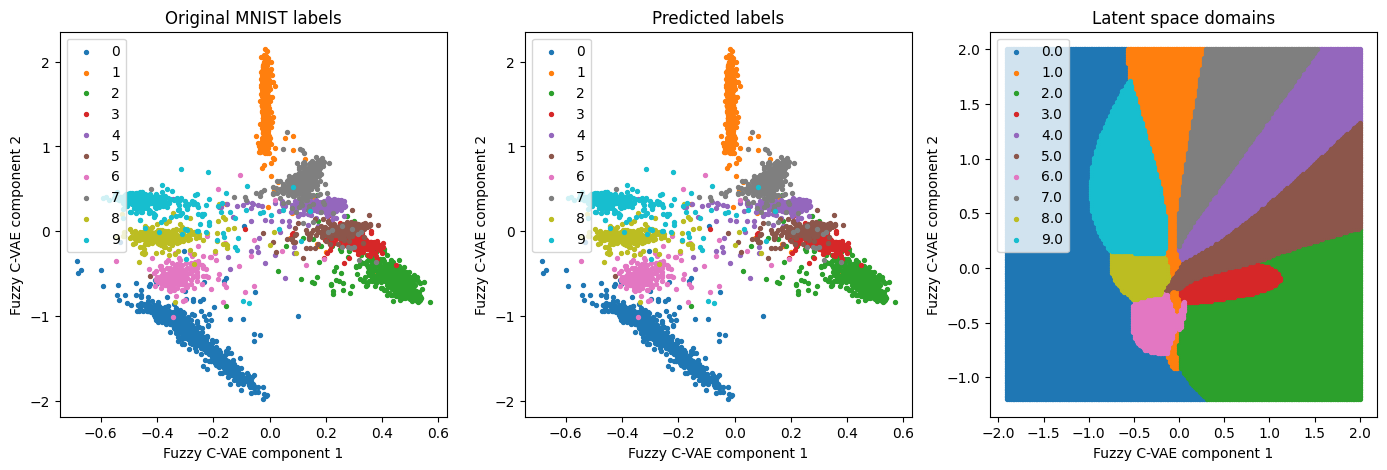

In [436]:
import matplotlib.colors
figure, axis = plt.subplots(1, 3, figsize=(17, 5)) 

class_scatter(axis[0], z_all[:, 0], z_all[:, 1], y_all, f"{mask} component 1", f"{mask} component 2", f'Original MNIST labels', s=8)
class_scatter(axis[1], z_all[:, 0], z_all[:, 1], y_all, f"{mask} component 1", f"{mask} component 2", f'Predicted labels', s=8)
class_scatter(axis[2], *domains_scatter_points.T, f"{mask} component 1", f"{mask} component 2", f'Latent space domains', s=8)

if is_fuzzy_loss_active:
    figure.savefig('./papers/iiti24/fig3-fcvae-classification.eps', format="eps", transparent=False)
plt.show()

## Data generation

[[-0.457877    0.38119197]
 [-0.40905163  0.4817815 ]
 [-0.3602262   0.58237106]
 [-0.31140083  0.6829606 ]
 [-0.26257545  0.78355014]
 [-0.21375006  0.8841397 ]
 [-0.16492465  0.9847293 ]
 [-0.11609927  1.0853188 ]
 [-0.06727389  1.1859083 ]
 [-0.01844851  1.286498  ]]
torch.Size([10, 2])


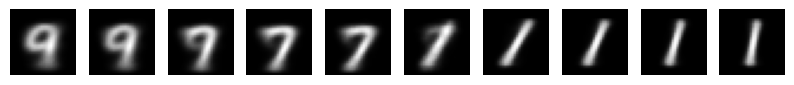

In [511]:
n = 10
from_ = cluster_centroids_from_data[9]
to_ = cluster_centroids_from_data[1]

path_from_4_to_9 = np.linspace(from_, to_, n)
print(path_from_4_to_9)
path_from_4_to_9 = [torch.FloatTensor(a) for a in path_from_4_to_9]

z = torch.stack(path_from_4_to_9, dim=0).to(device)
print(z.shape)
samples = model.decoder_pass(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('papers/iiti24/fig4a-sample-generation.eps', format="eps")
plt.show()


[[-0.31140083  0.6829606 ]
 [-0.28970066  0.7276671 ]
 [-0.26800048  0.77237356]
 [-0.24630031  0.81708   ]
 [-0.22460014  0.8617865 ]
 [-0.20289996  0.90649295]
 [-0.18119979  0.9511994 ]
 [-0.15949962  0.9959059 ]
 [-0.13779944  1.0406123 ]
 [-0.11609927  1.0853188 ]]
torch.Size([10, 2])


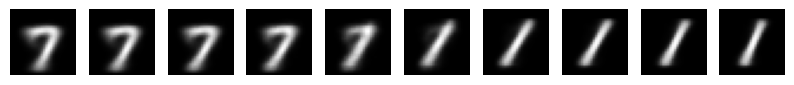

In [513]:
n = 10
from_ = cluster_centroids_from_data[9]
to_ = cluster_centroids_from_data[1]

path_from_4_to_9 = np.linspace(from_, to_, n)
from_ = path_from_4_to_9[3]
to_ = path_from_4_to_9[-3]
path_from_4_to_9 = np.linspace(from_, to_, n)
print(path_from_4_to_9)
path_from_4_to_9 = [torch.FloatTensor(a) for a in path_from_4_to_9]

z = torch.stack(path_from_4_to_9, dim=0).to(device)
print(z.shape)
samples = model.decoder_pass(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('papers/iiti24/fig4a-sample-generation.eps', format="eps")
plt.show()


tensor([[ 0.2439, -0.3737]], device='cuda:0', grad_fn=<SplitBackward0>)
[[0.1 0.  0.9 0.  0.  0.  0.1 0.  0.  0. ]]


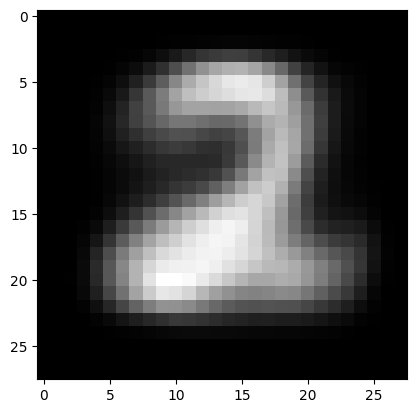

In [611]:

mu, std, z, fz = model.half_pass(test_data[1][0].reshape((1,1,28,28)).to(device))

# mu[0][0] = -2.8242958
# mu[0][1] = -0.39727297

print(mu)
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)
print(fz.cpu().detach().numpy())
samples = model.decoder_pass(mu)
#samples = torch.sigmoid(samples)
plt.imshow(samples[0].view(28, 28).cpu().detach().numpy(), cmap='gray')
    

## Anomaly detection

In [32]:
emnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [33]:
import pandas as pd

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.csv")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 

emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32) for a in emnist_x]

len(emnist_x)

/tmp/ipykernel_9600/2301690307.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32) for a in emnist_x]


103600

In [34]:
emnist_mapping = pd.read_csv("./data/EMNIST/emnist-letters-mapping.txt", sep=' ', header=None)
emnist_mapping.columns=("EMNIST","UP","LO")
emnist_mapping["Letter"] = emnist_mapping.apply(lambda row: chr(row["UP"])+chr(row["LO"]), axis=1)
emnist_mapping = dict(zip(emnist_mapping["EMNIST"], emnist_mapping["Letter"]))
emnist_mapping

{1: 'Aa',
 2: 'Bb',
 3: 'Cc',
 4: 'Dd',
 5: 'Ee',
 6: 'Ff',
 7: 'Gg',
 8: 'Hh',
 9: 'Ii',
 10: 'Jj',
 11: 'Kk',
 12: 'Ll',
 13: 'Mm',
 14: 'Nn',
 15: 'Oo',
 16: 'Pp',
 17: 'Qq',
 18: 'Rr',
 19: 'Ss',
 20: 'Tt',
 21: 'Uu',
 22: 'Vv',
 23: 'Ww',
 24: 'Xx',
 25: 'Yy',
 26: 'Zz'}

In [42]:

model.eval()

anomaly_mu = defaultdict(list)


with torch.no_grad():
    for data, label in zip(emnist_x, emnist_y):
        data = data.view((-1,1,28,28)).to(device)
        mu, x_recon, flabels= model.forward(data)
        
        anomaly_mu[emnist_mapping[label]].append(mu.cpu().numpy())

anomaly_mu

defaultdict(list,
            {'Aa': [array([[ 0.12704556,  0.00789426,  0.266714  ,  0.00470088, -0.30651262,
                      -0.98302674]], dtype=float32),
              array([[-1.1046933e-01, -1.6659679e-01, -1.7551592e-01,  1.9952375e-04,
                       1.9561976e-01,  8.9872813e-01]], dtype=float32),
              array([[ 0.44350332, -0.26332712, -0.42313233, -0.00819312, -0.75732833,
                       0.08109183]], dtype=float32),
              array([[ 0.31390515, -0.25663197,  0.0431575 , -0.02663954, -0.9545687 ,
                       0.9057762 ]], dtype=float32),
              array([[ 0.01639419,  0.582093  ,  0.20112494,  0.02446201, -0.85945064,
                      -0.3066325 ]], dtype=float32),
              array([[-0.02339824, -0.0311018 ,  0.3364107 ,  0.01312779, -0.3538713 ,
                       0.50430274]], dtype=float32),
              array([[-0.01526333,  0.2192828 ,  0.12735362,  0.00491527, -0.56604874,
                      -0.524181

In [36]:
from sklearn.ensemble import IsolationForest

detectors = {}

if is_fuzzy_loss_active:
    for numb in range(0,10):
        isolf = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0)
        isolf.fit(data_centroids_dict[numb])
        detectors[numb] = isolf
else:
    isolf = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0)
    isolf.fit(z_all)
    detectors[0] = isolf

anomaly_rates = {}
for letters_pair in emnist_mapping.values():
   
    input = np.reshape(anomaly_mu[letters_pair],(len(anomaly_mu[letters_pair]), latent_dim))

    if is_fuzzy_loss_active:
        scores = [detectors[a].predict(input) for a in detectors.keys()]
        overall_score = np.max(scores,axis = 0)
        overall_score = [1 if a==-1 else 0 for a in overall_score]
        anomaly_rates[letters_pair] = (np.mean(overall_score), np.std(overall_score))
    else:
        scores = detectors[0].predict(input)
        overall_score = [1 if a==-1 else 0 for a in scores]
        anomaly_rates[letters_pair] = (np.mean(overall_score), np.std(overall_score))

mean_emnist_ar = np.mean([m for m, _ in anomaly_rates.values()])
p10_emnist_ar = np.percentile([m for m, _ in anomaly_rates.values()], 20)
p90_emnist_ar = np.percentile([m for m, _ in anomaly_rates.values()], 80)
print(is_fuzzy_cvae)
print(f"Anomality rate on EMNIST mean {mean_emnist_ar} p10 {p10_emnist_ar} p90 {p90_emnist_ar}")
print([m for m, _ in anomaly_rates.values()])

True
Anomality rate on EMNIST mean 0.5639151531971042 p10 0.43904567937154493 p90 0.6571428571428571
[0.6549094375595805, 0.6839847473784557, 0.8667930789286561, 0.6391138637446403, 0.8614585791833844, 0.413447782546495, 0.6394265232974911, 0.5660511363636364, 0.5018921475875118, 0.6151832460732984, 0.6271826333176026, 0.5810201660735469, 0.3900523560209424, 0.48667466986794716, 0.2894486692015209, 0.3054373522458629, 0.6571428571428571, 0.5214505807063285, 0.7463080168776371, 0.47380675203725264, 0.5896460953495174, 0.5689655172413793, 0.17937481741162722, 0.43904567937154493, 0.48653344917463076, 0.8774438284213598]


In [37]:
mnist_anomaly_rates = {}
for digit, data in enumerate(Z):
    scores = [detectors[a].predict(data) for a in detectors.keys()]
    overall_score = np.max(scores,axis = 0)
    overall_score = [1 if a==-1 else 0 for a in overall_score]
    mnist_anomaly_rates[digit] = (np.mean(overall_score), np.std(overall_score))

mean_mnist_ar = np.mean([m for m, _ in mnist_anomaly_rates.values()])
p10_mnist_ar = np.percentile([m for m, _ in mnist_anomaly_rates.values()], 20)
p90_mnist_ar = np.percentile([m for m, _ in mnist_anomaly_rates.values()], 80)
print(f"Anomality rate on MNIST mean {mean_mnist_ar} p10 {p10_mnist_ar} p90 {p90_mnist_ar}")
print([m for m, _ in mnist_anomaly_rates.values()])
# scores = np.array([detectors[a].predict(z_all) for a in detectors.keys()])
# numbers_score = np.max(scores, axis=0)
# numbers_score = [1 if a==-1 else 0 for a in numbers_score]

# p10_mnist_ar = np.percentile(numbers_score, 20)
# p90_mnist_ar = np.percentile(numbers_score, 80)
# print(f"Anomality rate on pure numbers mean {np.mean(numbers_score)} p20 {p10_mnist_ar} p80 {p90_mnist_ar}")

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

<Figure size 500x500 with 0 Axes>

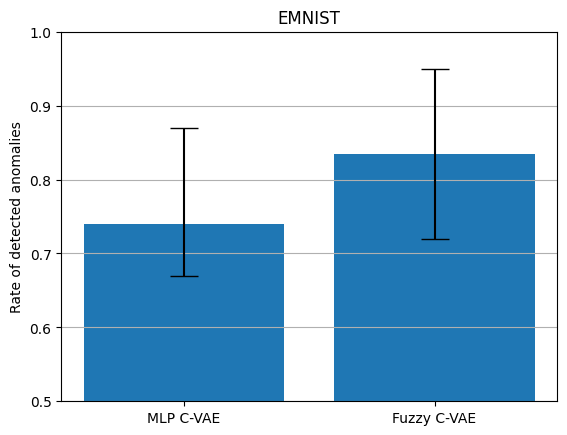

<Figure size 500x500 with 0 Axes>

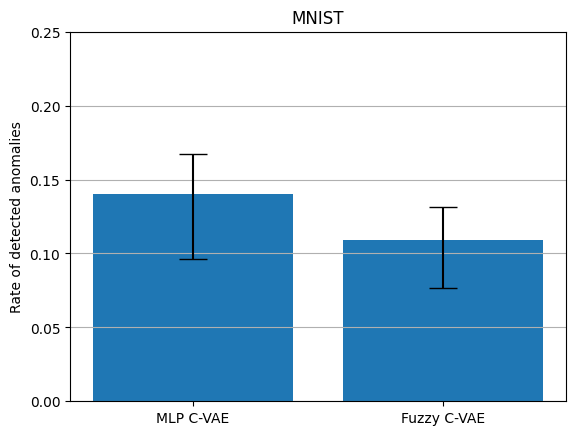

In [94]:
import matplotlib.pyplot as plt
import numpy as np

fz_mean_mnist_ar = 0.1088
fz_p10_mnist_ar = 0.07639
fz_p90_mnist_ar = 0.1315
mlp_mean_mnist_ar = 0.14
mlp_p10_mnist_ar = 0.0961
mlp_p90_mnist_ar = 0.1675

fz_mean_emnist_ar = 0.835
fz_p10_emnist_ar = 0.72
fz_p90_emnist_ar = 0.95
mlp_mean_emnist_ar = 0.74
mlp_p10_emnist_ar = 0.67
mlp_p90_emnist_ar = 0.87

experements = ["Fuzzy C-VAE", "MLP C-VAE"]
y_pos = np.arange(len(experements))

M = [fz_mean_emnist_ar, mlp_mean_emnist_ar]
error = [[fz_mean_emnist_ar - fz_p10_emnist_ar, mlp_mean_emnist_ar - mlp_p10_emnist_ar], [fz_p90_emnist_ar - fz_mean_emnist_ar, mlp_p90_emnist_ar - mlp_mean_emnist_ar]]
plt.figure(figsize=(5, 5))
fig, ax = plt.subplots()
ax.bar(y_pos, M, yerr=error, align='center', capsize=10)
ax.set_xticks(y_pos, labels=experements)
ax.invert_xaxis()  # labels read top-to-bottom
ax.set_ylabel('Rate of detected anomalies')
ax.set_title('EMNIST')
ax.set_ylim(0.5, 1)
ax.yaxis.grid(True)
plt.savefig('./papers/iiti24/emnist-anomaly-ratio.eps', format="eps")
plt.show()

M = [fz_mean_mnist_ar, mlp_mean_mnist_ar]
error = [[fz_mean_mnist_ar - fz_p10_mnist_ar, mlp_mean_mnist_ar - mlp_p10_mnist_ar], [fz_p90_mnist_ar - fz_mean_mnist_ar, mlp_p90_mnist_ar - mlp_mean_mnist_ar]]
plt.figure(figsize=(5, 5))
fig, ax = plt.subplots()
ax.bar(y_pos, M, yerr=error, align='center', capsize=10)
ax.set_xticks(y_pos, labels=experements)
ax.invert_xaxis()  # labels read top-to-bottom
ax.set_ylabel('Rate of detected anomalies')
ax.set_title('MNIST')
ax.set_ylim(0, 0.25)
ax.yaxis.grid(True)
plt.savefig('./papers/iiti24/mnist-anomaly-ratio.eps', format="eps")
plt.show()

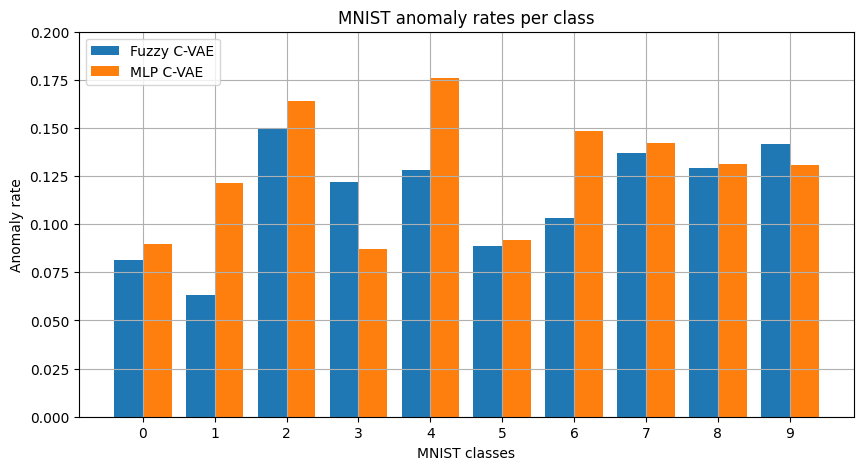

In [115]:
#experements = ['0-9']
experements = []
experements.extend(mnist_anomaly_rates.keys())
x_pos = np.arange(len(experements))

data_mlp = [0.08979591836734693, 0.12158590308370044, 0.16375968992248063, 0.08712871287128712, 0.17617107942973523, 0.09192825112107623, 0.14822546972860126, 0.14202334630350194, 0.13141683778234087, 0.13082259663032705]
data_fuzzy = [0.08163265306122448, 0.06343612334801763, 0.1501937984496124, 0.12178217821782178, 0.12830957230142567, 0.08856502242152467, 0.10334029227557412, 0.13715953307392997, 0.1293634496919918, 0.14172447968285432]
plt.figure(figsize=(10, 5))
#plt.bar(x_pos - 0.2, data_fuzzy, width=0.4, align='center', label='Fuzzy C-VAE')
#plt.bar(x_pos + 0.2, data_mlp, width=0.4, align='center', label='MLP C-VAE')
#data = np.array(data_fuzzy)-np.array(data_mlp)
#data_fz = np.maximum(data, 0)
#data_mlp = np.minimum(data, 0)

plt.bar(x_pos - 0.2, data_fuzzy, width=0.4, align='center', label='Fuzzy C-VAE')
plt.bar(x_pos + 0.2, data_mlp, width=0.4, align='center', label='MLP C-VAE')

#plt.bar(x_pos, , width=0.8, align='center', label='MLP C-VAE')
#plt.bar(x_pos + 0.2, data_vea, width=0.28, align='center', label='Vanilla VAE')
plt.xticks(x_pos, labels=experements)
plt.xlabel('MNIST classes')
plt.ylabel('Anomaly rate')
plt.title('MNIST anomaly rates per class')
plt.ylim(0, 0.2)
#plt.yticks(np.linspace(-0.3, 0.3, 7), labels=np.abs(np.round(np.linspace(-0.3, 0.3, 7), 1)))
plt.grid(True)
plt.savefig('./papers/iiti24/all-emnist-anomaly-ratio.eps', format="eps")
plt.legend(loc='upper left')
plt.show()

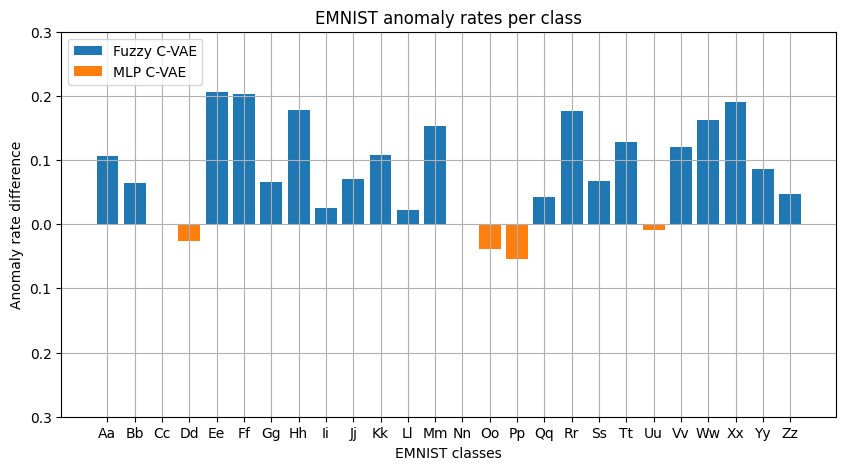

In [58]:
#experements = ['0-9']
experements = []
experements.extend(anomaly_rates.keys())
x_pos = np.arange(len(experements))

data_mlp = [0.7933746425166825, 0.8472354623450906, 0.8933396539464328, 0.8556455454978561, 0.7373141373613405, 0.7088698140200286, 0.8874551971326164, 0.7713068181818182, 0.9668874172185431, 0.8829128986197049, 0.7928268050967437, 0.9698695136417557, 0.4683484055211804, 0.6698679471788715, 0.23241444866920152, 0.6995271867612293, 0.8762691853600945, 0.5375681441099787, 0.8736814345991561, 0.7433061699650757, 0.6794384322901433, 0.7524839275277615, 0.1656441717791411, 0.7649112598196102, 0.7946713003185636, 0.87248322147651]
data_fuzzy = [0.8996663489037178, 0.9111058150619638, 0.8931026309552027, 0.828966174368747, 0.9433561482180788, 0.9117787315212208, 0.953405017921147, 0.9493371212121212, 0.9921948912015137, 0.953117563065207, 0.9013685700802265, 0.9926453143534995, 0.6216087577344122, 0.668187274909964, 0.1936787072243346, 0.6453900709219859, 0.9190082644628099, 0.7143872955676701, 0.9406645569620253, 0.8719441210710128, 0.6700789704591986, 0.8728813559322034, 0.32865907099035935, 0.9549025312772766, 0.8803938604112366, 0.9200466880653633]
#data_vea = [0.32, 0.91, 0.01, 0.24, 0.01, 0.24, 0.08, 0.15, 0.14, 0.33, 0.47, 0.11, 0.16, 0.64, 0.54, 0.61, 0.08, 0.61, 0.29, 0.83, 0.23, 0.55, 0.63, 0.13, 0.42, 0.79, 0.20]
plt.figure(figsize=(10, 5))
#plt.bar(x_pos - 0.2, data_fuzzy, width=0.4, align='center', label='Fuzzy C-VAE')
#plt.bar(x_pos + 0.2, data_mlp, width=0.4, align='center', label='MLP C-VAE')
data = np.array(data_fuzzy)-np.array(data_mlp)
data_fz = np.maximum(data, 0)
data_mlp = np.minimum(data, 0)

plt.bar(x_pos, data_fz, width=0.8, align='center', label='Fuzzy C-VAE')
plt.bar(x_pos, data_mlp, width=0.8, align='center', label='MLP C-VAE')

#plt.bar(x_pos, , width=0.8, align='center', label='MLP C-VAE')
#plt.bar(x_pos + 0.2, data_vea, width=0.28, align='center', label='Vanilla VAE')
plt.xticks(x_pos, labels=experements)
plt.xlabel('EMNIST classes')
plt.ylabel('Anomaly rate difference')
plt.title('EMNIST anomaly rates per class')
plt.ylim(-0.3, 0.3)
plt.yticks(np.linspace(-0.3, 0.3, 7), labels=np.abs(np.round(np.linspace(-0.3, 0.3, 7), 1)))
plt.grid(True)
plt.savefig('./papers/iiti24/all-emnist-anomaly-ratio.eps', format="eps")
plt.legend(loc='upper left')
plt.show()

In [544]:
anomaly_stats = []

anomaly_stats.append(
    {
            'Letters': '0123456789',
            'Detected anomaly rate': np.mean(numbers_score),
    }
)

for k in anomaly_rates.keys():
    anomaly_stats.append(
        {
            'Letters': k,
            'Detected anomaly rate': anomaly_rates[k][0],
        }
    )


pd.DataFrame(anomaly_stats).sort_values('Detected anomaly rate')

Letters  Detected anomaly rate
0   0123456789               0.113200
15          Oo               0.186549
23          Ww               0.340929
13          Mm               0.629938
14          Nn               0.706122
21          Uu               0.708687
16          Pp               0.723877
18          Rr               0.762977
4           Dd               0.832778
22          Vv               0.872005
3           Cc               0.877696
20          Tt               0.883586
25          Yy               0.891109
1           Aa               0.913489
26          Zz               0.918004
11          Kk               0.923077
2           Bb               0.923499
5           Ee               0.926835
17          Qq               0.927745
6           Ff               0.935384
19          Ss               0.940401
10          Jj               0.948596
8           Hh               0.951941
7           Gg               0.952927
24          Xx               0.966541
12          Ll               0.992645
9           Ii               0.993851

In [545]:
latex_table = pd.DataFrame(anomaly_stats, index=None).sort_values('Detected anomaly rate').to_latex( escape = False,index=False, float_format="{:.2f}".format)
print(latex_table)

\begin{tabular}{lr}
\toprule
Letters & Detected anomaly rate \\
\midrule
0123456789 & 0.11 \\
Oo & 0.19 \\
Ww & 0.34 \\
Mm & 0.63 \\
Nn & 0.71 \\
Uu & 0.71 \\
Pp & 0.72 \\
Rr & 0.76 \\
Dd & 0.83 \\
Vv & 0.87 \\
Cc & 0.88 \\
Tt & 0.88 \\
Yy & 0.89 \\
Aa & 0.91 \\
Zz & 0.92 \\
Kk & 0.92 \\
Bb & 0.92 \\
Ee & 0.93 \\
Qq & 0.93 \\
Ff & 0.94 \\
Ss & 0.94 \\
Jj & 0.95 \\
Hh & 0.95 \\
Gg & 0.95 \\
Xx & 0.97 \\
Ll & 0.99 \\
Ii & 0.99 \\
\bottomrule
\end{tabular}



tensor([0.1461, 0.1255, 0.0421, 0.0695, 0.0488, 0.2392, 0.3370, 0.0381, 0.2042,
        0.1123], device='cuda:0')
tensor(0.3370, device='cuda:0')


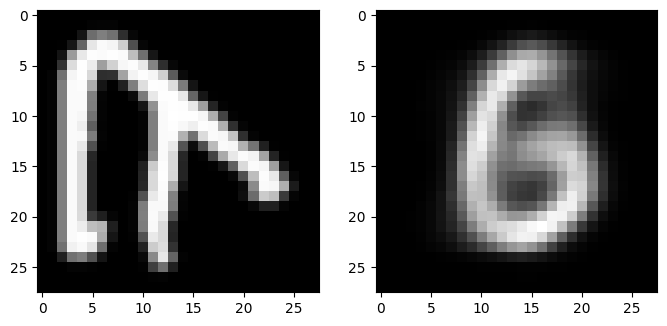

In [546]:
model.eval()

with torch.no_grad():
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    data = emnist_x[4009]
    data = data.view((-1,1,28,28)).to(device)
    mu, x_recon, flabels= model.forward(data)
    print(flabels[0])
    print(flabels[0][0:10].max())
    ax[0].imshow(data.view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[1].imshow(x_recon.view(28, 28).cpu().detach().numpy(), cmap='gray')